# 💊 BO2 - Identify Alternative Medications Based on Active Ingredients (INN)

## 🗺️ Roadmap

### 1️⃣ - Business Understanding

**Objective:** Recommend generic, biosimilar, or therapeutic alternative medications for a given drug, based on the International Nonproprietary Name (INN).

#### Key Questions:
- What are the primary use cases for patients, pharmacists, and doctors?
- What are the key features affecting alternative medication recommendations?
- Why are factors like INN, Therapeutic Class, and Drug Type important?

---

### 2️⃣ - Data Understanding

**Data Sources:** Medication data from `liste_amm.xls`.

#### Key Attributes:
- **INN**: Active ingredient.
- **Dosage**: Dosage of the drug.
- **Form**: Galenic form (tablet, capsule, etc.).
- **Therapeutic Class**: Class and subclass of the drug.
- **Laboratory**: Pharmaceutical laboratory.
- **Drug Type (G/P/B)**: Generic, princeps, biosimilar.
- **VEIC**: Classification (Vital, Essential, Non-Essential).

---

### 3️⃣ - Data Preparation

#### **Data Cleaning:**
- Remove duplicates.
- Handle missing values.
- Standardize formats (uppercase, accents, etc.).

#### **Feature Engineering:**
- Create a **Characteristics** column by combining `INN`, `Dosage`, `Form`, and `Therapeutic Class`.
- Extract numerical dosage and normalize it.
- Encode categorical variables (`Form`, `Class`, `G/P/B`, `VEIC`) using One-Hot Encoding.

#### **Vectorization:**
- Use **TF-IDF** to vectorize the `Characteristics` column.

---

### 4️⃣ - Modeling

#### **Content-Based Filtering:**
- Use **cosine similarity** to recommend drugs with similar characteristics.
- Apply a **deep learning model**.

#### **Direct Mapping of Alternatives:**
- Create a direct mapping between drugs and their alternatives based on **INN**.

---

### 5️⃣ - Evaluation

#### **Metrics:**
- **Precision @K**: Proportion of relevant recommendations among the top K.
- **Recall @K**: Proportion of correct alternatives captured in the top K recommendations.
- **MRR (Mean Reciprocal Rank)**: Measures the quality of recommendation ranking.

---

### 6️⃣ - Deployment

#### **API Development:**
- Develop an API using **FastAPI** .
- **Input**: Drug name or INN.
- **Output**: List of alternatives with details.

#### **User Interface:**
- Integrate the API into a **React frontend** for easy use by pharmacists and doctors.

#### **Cloud Deployment:**
- Deploy the API on a cloud platform (**AWS, GCP, Azure, Vercel**).

---


## Import libraries

In [4]:
#Importing necessary Libraries
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import itertools
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pickle
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.sparse import hstack

In [5]:
!pip install tensorflow
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.2
    Uninstalling protobuf-3.20.2:
      Successfully uninstalled protobuf-3.20.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddlepaddle 2.6.2 requires protobuf<=3.20.2,>=3.1.0; platform_system == "Windows", but you have protobuf 5.29.4 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable


# Exploratory Data Analysis(EDA)

# 🏥 Column Descriptions

## **1. Name** 🏷️  
**Commercial designation** of the drug (e.g., *5-FLUOROURACIL*).  

## **2. Dosage** 💊  
**Active ingredient quantity** per unit (e.g., *250 MG*, *1000 mg/20 ml*).  

## **3. Form** 🧪  
**Pharmaceutical formulation** (e.g., *Injectable solution*, *Oral suspension powder*).  

## **4. Presentation** 📦  
**Packaging format** (e.g., *B/5/5ML* means a box containing 5 ampoules of 5 mL).  

## **5. INN (International Nonproprietary Name - DCI in French)** 🏷️  
**Generic name** of the active ingredient (e.g., *FLUOROURACIL* for *5-FLUOROURACIL*).  

## **6. Class** 🔬  
**Therapeutic category** of the drug (e.g., *ANTINEOPLASTIC AND IMMUNOMODULATORY AGENTS*).  

## **7. Subclass** 🔍  
**More specific classification** within the therapeutic class (e.g., *ANTINEOPLASTIC AGENTS* for anticancer treatments).  

## **8. Laboratory** 🏭  
**Pharmaceutical company** manufacturing the drug (e.g., *EBEWE Pharma*, *ADWYA*).  

## **9. Marketing Authorization (AMM in French)** 📜  
**Registration number** of the drug.  

## **10. Marketing Authorization Date** 📆  
**Date when the drug was approved for market release**.  

## **11. Primary Packaging** 📦  
**Type of direct packaging** (e.g., *Vial*, *Ampoule*).  

## **12. Primary Packaging Specification** 🏷️  
**Material used** for packaging (e.g., *Type I colorless glass*).  

## **13. Regulatory Classification (Tableau)** 📋  
**Regulatory classification** (e.g., *A* may indicate strict prescription drugs).  

## **14. Shelf Life** ⏳  
**Validity period** of the drug (in months, e.g., *24 months*).  

## **15. Indications** 🏥  
**List of conditions** the drug is prescribed for (e.g., *Colorectal cancer, Bacterial infections*).  

## **16. G/P/B (Drug Type)** 🧬  
**Type of drug classification:**  
- **G**: Generic  
- **P**: Princeps (original patented drug)  
- **B**: Biosimilar (alternative to a biological drug).  

## **17. VEIC (Vital and Essential Drug Classification)** 💡  
**Importance level of the drug:**  
- **Vital**: Essential for survival.  
- **Essential**: Important but less critical.  


In [8]:
df= pd.read_excel('liste_amm.xls')
df.head()

,Nom,Dosage,Forme,Présentation,DCI,Classe,Sous Classe,Laboratoire,AMM,Date AMM,Conditionnement primaire,Spécifocation Conditionnement primaire,tableau,Durée de conservation,Indications,G/P/B,VEIC
0,5-FLUOROURACIL,250 MG,Solution injectable,B/5/5ML,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943091H,2001-01-20,Ampoule,en verre,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
1,5-FLUOROURACILE EBEWE,1000 mg/20 ml,Solution injectable pour perfusion,B/1/20 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943093H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
2,5-FLUOROURACILE EBEWE,500 mg/10 ml,Solution injectable pour perfusion,B/5/10 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943092H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
3,ABBOTICINE,200 MG,Poudre pour suspension orale,FL/60ML,ERYTHROMYCINE,ANTIINFECTIEUX GENERAUX A USAGE SYSTEMIQUE,ANTIBACTERIENS (USAGE SYSTEMIQUE),ADWYA,9043061,1990-12-19,Flacon,en verre ambre,A,48,INFECTIONS DUES AUX GERMES SENSIBLES NOTAMMENT...,Princeps,Essentiel
4,ABEVMY,400 mg(25mg/ml),Solution à diluer pour perfusion,B/1FL/16ml,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,MYLAN PHARMACEUTICALS PRIVATE LIMITED,20343022H,2021-09-06,Flacon,en verrede type I,A,24,Cancer métastatique du colon ou du rectum\r- A...,Biosimilaire,Vital


In [9]:
# A clear vision about the dataset with the neumarical values
df.shape

(6059, 17)

# Data Understanding

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6059 entries, 0 to 6058
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Nom                                     6059 non-null   object        
 1   Dosage                                  5514 non-null   object        
 2   Forme                                   6059 non-null   object        
 3   Présentation                            6054 non-null   object        
 4   DCI                                     6058 non-null   object        
 5   Classe                                  6059 non-null   object        
 6   Sous Classe                             6059 non-null   object        
 7   Laboratoire                             6059 non-null   object        
 8   AMM                                     6059 non-null   object        
 9   Date AMM                                6059 non-nul

In [12]:
df.describe()


,Date AMM,Durée de conservation
count,6059,6059.000000
mean,2011-05-11 14:54:33.807558912,30.930186
min,1987-09-08 00:00:00,0.000000
25%,2005-10-01 00:00:00,24.000000
50%,2013-03-12 00:00:00,24.000000
75%,2018-03-07 00:00:00,36.000000
max,2024-01-09 00:00:00,60.000000
std,NaN,9.261288


In [13]:
df.dtypes

Nom                                               object
Dosage                                            object
Forme                                             object
Présentation                                      object
DCI                                               object
Classe                                            object
Sous Classe                                       object
Laboratoire                                       object
AMM                                               object
Date AMM                                  datetime64[ns]
Conditionnement primaire                          object
Spécifocation Conditionnement primaire            object
tableau                                           object
Durée de conservation                              int64
Indications                                       object
G/P/B                                             object
VEIC                                              object
dtype: object

<Axes: ylabel='count'>

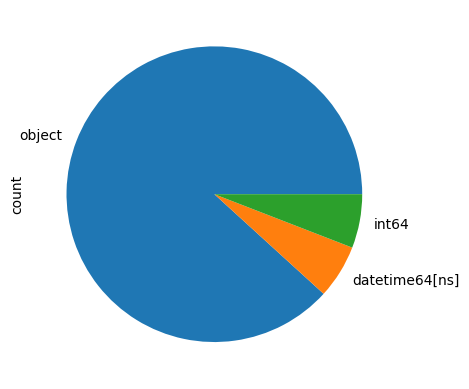

In [14]:
#3.Visualisation
#statistique sur le nombre de chaque type des colonnes
df.dtypes.value_counts()
df.dtypes.value_counts().plot.pie()

In [15]:
# Summarize the dataset to check for missing values and unique entries in each column.
summary = df.describe(include='all')
missing_values = df.isnull().sum()
unique_values = df.nunique()

# Combine the summaries into a single DataFrame for better visualization
summary_df = pd.DataFrame({'Unique Values': unique_values, 'Missing Values': missing_values})

# Display the summary DataFrame
print(summary_df)

                                        Unique Values  Missing Values
Nom                                              3339               0
Dosage                                           1169             545
Forme                                             149               0
Présentation                                     1421               5
DCI                                              1086               1
Classe                                             14               0
Sous Classe                                        85               0
Laboratoire                                       436               0
AMM                                              6047               0
Date AMM                                         1544               0
Conditionnement primaire                           28               0
Spécifocation Conditionnement primaire           2302             125
tableau                                             4               0
Durée de conservatio

In [16]:
# Identify rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Display the rows with missing values
print(missing_rows.head())

                        Nom Dosage                                Forme  \
53            ACTIFED RHUME    NaN                             Comprimé   
54  ACTIFED RHUME ET FIEVRE    NaN                             Comprimé   
55       ACTIFED VITAMINE C    NaN                   Comprimé pelliculé   
65               ACTISOUFRE    NaN  Solution pour pulvérisation buccale   
66           ACTIVEX ADULTE    NaN       Granulés pour solution buvable   

   Présentation                                       DCI  \
53         B/20              PSEUDOEPHEDRINE+TRIPROLIDINE   
54         B/16  PARACETAMOL+PSEUDOEPHEDRINE+TRIPROLIDINE   
55         B/20    PARACETAMOL+PSEUDOEPHEDRINE+VITAMINE C   
65    FL/100 ml             MONOSULFURE DE SODIUM+LEVURES   
66  B/8 sachets        PARACETAMOL+PHENIRAMINE+VITAMINE C   

                  Classe                         Sous Classe Laboratoire  \
53  SYSTEME RESPIRATOIRE             MEDICAMENTS POUR LE NEZ      TERIAK   
54  SYSTEME RESPIRATOIRE      

In [17]:
def dataoverview(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [18]:
dataoverview(df, "A Overview about the dataset")

A Overview about the dataset:

Rows: 6059

Number of features: 17

Features:
['Nom', 'Dosage', 'Forme', 'Présentation', 'DCI', 'Classe', 'Sous Classe', 'Laboratoire', 'AMM', 'Date AMM', 'Conditionnement primaire', 'Spécifocation Conditionnement primaire', 'tableau', 'Durée de conservation', 'Indications', 'G/P/B', 'VEIC']

Missing values: 747

Unique values:
Nom                                       3339
Dosage                                    1169
Forme                                      149
Présentation                              1421
DCI                                       1086
Classe                                      14
Sous Classe                                 85
Laboratoire                                436
AMM                                       6047
Date AMM                                  1544
Conditionnement primaire                    28
Spécifocation Conditionnement primaire    2302
tableau                                      4
Durée de conservation       

In [19]:
# Check for missing values in the combined dataset
missing_values = df.isnull().sum()


# Display the missing values for each column
missing_values[missing_values > 0]

Dosage                                    545
Présentation                                5
DCI                                         1
Spécifocation Conditionnement primaire    125
Indications                                 8
VEIC                                       63
dtype: int64

In [20]:
# Fill missing values in the remaining crucial columns
df['Dosage'].fillna(df['Dosage'].mode()[0], inplace=True)
df['DCI'].fillna(df['DCI'].mode()[0], inplace=True)

# Check if there are any missing values left in the original dataset after filling
missing_values_final = df.isnull().sum()
missing_values_final[missing_values_final > 0]

Présentation                                5
Spécifocation Conditionnement primaire    125
Indications                                 8
VEIC                                       63
dtype: int64

In [21]:
# Summarize the dataset to check for missing values and unique entries in each column.
summary = df.describe(include='all')
missing_values = df.isnull().sum()
unique_values = df.nunique()

# Combine the summaries into a single DataFrame for better visualization
summary_df = pd.DataFrame({'Unique Values': unique_values, 'Missing Values': missing_values})

# Display the summary DataFrame
print(summary_df)

                                        Unique Values  Missing Values
Nom                                              3339               0
Dosage                                           1169               0
Forme                                             149               0
Présentation                                     1421               5
DCI                                              1086               0
Classe                                             14               0
Sous Classe                                        85               0
Laboratoire                                       436               0
AMM                                              6047               0
Date AMM                                         1544               0
Conditionnement primaire                           28               0
Spécifocation Conditionnement primaire           2302             125
tableau                                             4               0
Durée de conservatio

## Convert dataset to CSV

In [23]:
import pandas as pd

# Lire le fichier Excel
df = pd.read_excel('liste_amm.xls')

# Convertir en CSV
df.to_csv('liste_amm.csv', index=False, encoding='utf-8')

# Vérification
print("Conversion réussie ! Voici les premières lignes du CSV :")
pd.read_csv('liste_amm.csv').head()

Conversion réussie ! Voici les premières lignes du CSV :


,Nom,Dosage,Forme,Présentation,DCI,Classe,Sous Classe,Laboratoire,AMM,Date AMM,Conditionnement primaire,Spécifocation Conditionnement primaire,tableau,Durée de conservation,Indications,G/P/B,VEIC
0,5-FLUOROURACIL,250 MG,Solution injectable,B/5/5ML,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943091H,2001-01-20,Ampoule,en verre,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
1,5-FLUOROURACILE EBEWE,1000 mg/20 ml,Solution injectable pour perfusion,B/1/20 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943093H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
2,5-FLUOROURACILE EBEWE,500 mg/10 ml,Solution injectable pour perfusion,B/5/10 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943092H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital
3,ABBOTICINE,200 MG,Poudre pour suspension orale,FL/60ML,ERYTHROMYCINE,ANTIINFECTIEUX GENERAUX A USAGE SYSTEMIQUE,ANTIBACTERIENS (USAGE SYSTEMIQUE),ADWYA,9043061,1990-12-19,Flacon,en verre ambre,A,48,INFECTIONS DUES AUX GERMES SENSIBLES NOTAMMENT...,Princeps,Essentiel
4,ABEVMY,400 mg(25mg/ml),Solution à diluer pour perfusion,B/1FL/16ml,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,MYLAN PHARMACEUTICALS PRIVATE LIMITED,20343022H,2021-09-06,Flacon,en verrede type I,A,24,Cancer métastatique du colon ou du rectum\r- A...,Biosimilaire,Vital


# Prepare Data

## 1. Nettoyage des colonnes :

## 2. effacer les colonnes inutiles

In [27]:
import pandas as pd

# Charger les données
df = pd.read_excel('liste_amm.xls')

# Liste des colonnes à conserver
colonnes_a_conserver = ['Nom', 'DCI', 'Dosage', 'Forme','Laboratoire','Classe', 'Durée de conservation', 'G/P/B', 'VEIC']

# Supprimer les colonnes non cruciales
df = df[colonnes_a_conserver]

# Afficher les premières lignes du DataFrame nettoyé
print(df.head())

                     Nom            DCI           Dosage  \
0         5-FLUOROURACIL  FLUOROURACILE           250 MG   
1  5-FLUOROURACILE EBEWE  FLUOROURACILE    1000 mg/20 ml   
2  5-FLUOROURACILE EBEWE  FLUOROURACILE     500 mg/10 ml   
3             ABBOTICINE  ERYTHROMYCINE           200 MG   
4                 ABEVMY    BEVACIZUMAB  400 mg(25mg/ml)   

                                Forme                            Laboratoire  \
0                 Solution injectable                           EBEWE Pharma   
1  Solution injectable pour perfusion                           EBEWE Pharma   
2  Solution injectable pour perfusion                           EBEWE Pharma   
3        Poudre pour suspension orale                                  ADWYA   
4    Solution à diluer pour perfusion  MYLAN PHARMACEUTICALS PRIVATE LIMITED   

                                       Classe  Durée de conservation  \
0       ANTINEOPLASIQUES ET IMMUNOMODULATEURS                     24   
1       ANTINE

## Suprimer les doublons

In [29]:
# Nettoyage des données
df = df.drop_duplicates()

## Gérer les valeurs manquantes

In [31]:
df['Dosage'] = df['Dosage'].fillna('Inconnu')

In [32]:
df['DCI'] = df['DCI'].fillna('Inconnu')

In [33]:
df['G/P/B'] = df['G/P/B'].fillna('Inconnu')

In [34]:
df['Classe'] = df['Classe'].fillna('Inconnu')

In [35]:
df['VEIC'] = df['VEIC'].fillna('Non classé')

In [36]:
df['Durée de conservation'] = df['Durée de conservation'].fillna(-1)

In [37]:
dataoverview(df, "A Overview about the dataset")

A Overview about the dataset:

Rows: 5042

Number of features: 9

Features:
['Nom', 'DCI', 'Dosage', 'Forme', 'Laboratoire', 'Classe', 'Durée de conservation', 'G/P/B', 'VEIC']

Missing values: 0

Unique values:
Nom                      3339
DCI                      1087
Dosage                   1170
Forme                     149
Laboratoire               436
Classe                     14
Durée de conservation      21
G/P/B                       3
VEIC                        5
dtype: int64


## Standarlization des colonnes

In [39]:
df['Nom'] = df['Nom'].str.upper().str.strip()  # Standardiser les noms
df['DCI'] = df['DCI'].str.upper().str.strip()  # Standardiser la DCI
df['Dosage'] = df['Dosage'].str.upper().str.strip()  # Standardiser le dosage
df['Forme'] = df['Forme'].str.upper().str.strip()  # Standardiser la forme
df['Classe'] = df['Classe'].str.upper().str.strip()  # Standardiser la classe

In [40]:
df.columns


Index(['Nom', 'DCI', 'Dosage', 'Forme', 'Laboratoire', 'Classe',
       'Durée de conservation', 'G/P/B', 'VEIC'],
      dtype='object')

# Feature Engineering

In [42]:
# Nettoyage et préparation des données
df['Caractéristiques'] = df['DCI'] + ' ' + df['Dosage'] + ' ' + df['Forme'] + ' ' + df['Classe']
df['Caractéristiques'] = df['Caractéristiques'].str.lower().str.strip()

In [43]:
# df['Caractéristiques'] = df['DCI'] + ' ' + df['Dosage'] + ' ' + df['Forme'] + ' ' + df['Classe']

In [44]:
# Vérification/réintégration de DCI
if 'DCI' not in df.columns:
    df = pd.read_excel('liste_amm.xls')[['Nom', 'DCI', 'Laboratoire', 'Durée de conservation', 'G/P/B', 'VEIC', 'Caractéristiques']]
    df['Caractéristiques'] = df['DCI'] + ' ' + df['Caractéristiques']  # Fusion DCI + autres caractéristiques


In [45]:
# # Supprimer les colonnes d'origine
# df = df.drop(columns=['DCI', 'Dosage', 'Forme', 'Classe'])

# # Afficher le DataFrame mis à jour
# df.head()

- **TF-IDF** converts text in the `Caractéristiques` column into numerical features by tokenizing words and calculating their importance (TF-IDF score).  
- Each unique word becomes a column, resulting in hundreds or thousands of columns depending on the vocabulary size.  
- This matrix helps analyze text data for tasks like similarity calculation, clustering, or machine learning.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorisation des caractéristiques avec TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Caractéristiques'])

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [50]:
# Fonction pour obtenir des recommandations basées sur les caractéristiques
def get_recommendations(nom, cosine_sim):
    recommendations = []
    if nom in df['Nom'].values:
        idx = df[df['Nom'] == nom].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:4]  # Top 10
        med_indices = [i[0] for i in sim_scores]
        recommendations = df['Nom'].iloc[med_indices].tolist()
    else:
        recommendations.append("Médicament non trouvé.")
    return recommendations

# Exemple d'utilisation
medicament = 'ACARLYSE'
recommendations = get_recommendations(medicament, cosine_sim)
print("Recommandations pour {}: {}".format(medicament, recommendations))

Recommandations pour ACARLYSE: ['ACARLYSE', 'ALPHA-GLUCOFF', 'DIABICOR']


### recommendation system second version

In [ ]:
# Fusionner les caractéristiques importantes
df["Caractéristiques"] = (
    df["DCI"] + " " +
    df["Classe"] + " " +
    df["Sous Classe"] + " " +
    df["Forme"] + " " +
    df["Indications"] + " " +
    df["G/P/B"]
)

In [ ]:
from sentence_transformers import SentenceTransformer

# Charger un modèle BERT optimisé pour la similarité sémantique
model_bert = SentenceTransformer("distilbert-base-nli-mean-tokens")

# Convertir les descriptions en embeddings
df["bert_embedding"] = list(model_bert.encode(df["Caractéristiques"].tolist(), convert_to_tensor=False))


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Transformer les embeddings en matrice numpy
vectors = np.stack(df["bert_embedding"].values)

# Calculer la similarité cosinus entre les médicaments
similarity_matrix = cosine_similarity(vectors)


In [ ]:
def recommander_medicament(nom_medicament, df, similarity_matrix, top_n=5):
    try:
        index = df[df["Nom"] == nom_medicament].index[0]
    except IndexError:
        return "Médicament introuvable"

    scores = list(enumerate(similarity_matrix[index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    indices_medicaments = [i[0] for i in scores[1:top_n+1]]  # Exclure le médicament lui-même
    return df.iloc[indices_medicaments][["Nom", "DCI", "Dosage", "Classe", "Indications"]]

# Exemple d'utilisation
print(recommander_medicament("ABEVMY", df, similarity_matrix))
